# Combined Data Extraction Workflow

This notebook creates a merged NetCDF file with 2D arrays combining precipitation and SWE data at relevant coordinates. 

## Workflow Steps:

1. **File Combination** → Combined NetCDF files (If the downloaded data are in small chunks)
2. **Spatial data Extraction** → Extract data for the required area (If dataset contains data for a larger area than the study area)
3. **Create Merged 2D NetCDF** → Single file with combined data arrays

**Output**: Single merged NetCDF file with 2D precipitation and SWE arrays for the required study area

In [1]:
# Install required packages
#%pip install tqdm
#%pip install scipy
#%pip install scikit-learn
#%pip install pyyaml
#%pip install seaborn
#%pip install dask
#%pip install netcdf4

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob
import os
import sys
from pathlib import Path
import fnmatch
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Import required classes
from combine_casr_swe_files import CaSRFileCombiner
from extract_elevation_data_optimized import OptimizedElevationDataExtractor

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)



# Configuration


In [20]:
# Configuration
config = {
    'casr_SWE_input_dir': project_root / 'data' / 'input_data' / 'CaSR_SWE',
    'casr_P_input_dir': project_root / 'data' / 'input_data' / 'CaSR_precipitation',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'combined_casr_dir': project_root / 'data' / 'output_data' / 'combined_casr'/'1980_2024',
    'elevation_windows_dir': project_root / 'data' / 'output_data' / 'elevation'/'1980_2024',
    'merged_output_dir': project_root / 'data' / 'output_data' / 'merged_2d',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024',
    'window_size': 3,
    'time_sampling': 'monthly'
}

# Create output directories
config['merged_output_dir'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['merged_output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d


# 1. File combination 

SWE

In [30]:
print("Step 1: Combining CaSR files...")

combiner = CaSRFileCombiner(
    input_dir=str(config['casr_SWE_input_dir']),
    output_dir=str(config['combined_casr_dir'])
)

# Combine files temporally
combiner.combine_by_variable(combine_spatial=False, combine_temporal=True)

print("✓ Files combined")

2025-10-21 23:07:58,390 - INFO - Input directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE
2025-10-21 23:07:58,391 - INFO - Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024
2025-10-21 23:07:58,392 - INFO - Found 1 file groups:
2025-10-21 23:07:58,393 - INFO -   P_SWE_LAND: 36 files
2025-10-21 23:07:58,393 - INFO - 
Processing group: P_SWE_LAND
2025-10-21 23:07:58,394 - INFO - Combining 12 files temporally...
2025-10-21 23:07:58,394 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_1980-1983.nc
2025-10-21 23:07:58,404 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_1984-1987.nc
2025-10-21 23:07:58,413 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_1988-1991.nc
2025-10-21 23:07:58,422 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421

Step 1: Combining CaSR files...


2025-10-21 23:08:08,421 - INFO -   Saving to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024\CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_temporal_combined.nc
2025-10-21 23:08:22,476 - INFO -   Successfully saved combined file: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024\CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat421-455_temporal_combined.nc
2025-10-21 23:08:22,686 - INFO - Combining 12 files temporally...
2025-10-21 23:08:22,687 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1980-1983.nc
2025-10-21 23:08:22,699 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1984-1987.nc
2025-10-21 23:08:22,714 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1988-1991.nc
2025-10-21 23:08:22,729 - INFO -   Loading: CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat386-420_1992-1

✓ Files combined


In [32]:
# Print (lat, lon) pairs for the SWE dataset in CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_temporal_combined.nc
lats = swe_ds['original_lat'].values if 'original_lat' in swe_ds else None
lons = swe_ds['original_lon'].values if 'original_lon' in swe_ds else None

if lats is not None and lons is not None:
    print("Latitude, Longitude pairs in CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_temporal_combined.nc:")
    for lat, lon in zip(lats, lons):
        print(f"({lat:.6f}, {lon:.6f})")
else:
    print("SWE dataset does not contain 'original_lat' and 'original_lon' variables.")

Latitude, Longitude pairs in CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_temporal_combined.nc:
(51.462922, -116.150036)
(51.152693, -115.726219)
(50.918890, -115.439274)
(51.336459, -115.573577)
(51.132385, -115.090018)
(50.803778, -115.139700)
(51.311777, -115.118851)
(51.193008, -114.369761)
(50.891596, -114.682721)
(50.881730, -114.297293)
(50.555121, -114.422894)
(50.838084, -113.200038)
(50.359925, -111.786401)


Precipitation

In [18]:
print("Step 1: Combining CaSR files...")

combiner = CaSRFileCombiner(
    input_dir=str(config['casr_P_input_dir']),
    output_dir=str(config['combined_casr_dir'])
)

# Combine files temporally
combiner.combine_by_variable(combine_spatial=False, combine_temporal=True)

print("✓ Files combined")

2025-10-21 22:35:19,854 - INFO - Input directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation
2025-10-21 22:35:19,854 - INFO - Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024
2025-10-21 22:35:19,859 - INFO - Found 1 file groups:
2025-10-21 22:35:19,860 - INFO -   A_PR24_SFC: 36 files
2025-10-21 22:35:19,861 - INFO - 
Processing group: A_PR24_SFC
2025-10-21 22:35:19,863 - INFO - Combining 12 files temporally...
2025-10-21 22:35:19,864 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1980-1983.nc
2025-10-21 22:35:19,884 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1984-1987.nc
2025-10-21 22:35:19,902 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1988-1991.nc
2025-10-21 22:35:19,919 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon211-2

Step 1: Combining CaSR files...


2025-10-21 22:35:20,077 - INFO -   Concatenating datasets...
2025-10-21 22:35:31,025 - INFO -   Saving to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024\CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_temporal_combined.nc
2025-10-21 22:35:49,365 - INFO -   Successfully saved combined file: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\combined_casr\1980_2024\CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_temporal_combined.nc
2025-10-21 22:35:49,572 - INFO - Combining 12 files temporally...
2025-10-21 22:35:49,573 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1980-1983.nc
2025-10-21 22:35:49,599 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1984-1987.nc
2025-10-21 22:35:49,624 - INFO -   Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1988-1991.nc
2025-10-21 22:35:49,650 - INFO -  

✓ Files combined


In [19]:
print("Step 2: Extracting spatial windows...")

extractor = OptimizedElevationDataExtractor(
    elevation_dir=str(config['shapefile_dir']),
    combined_casr_dir=str(config['combined_casr_dir']),
    output_dir=str(config['elevation_windows_dir'])
)

# Load elevation data and extract windows
extractor.load_elevation_data()
results = extractor.process_all_files(
    file_types=['temporal'],
    time_sampling=config['time_sampling'],
    window_size=config['window_size'],
    output_format='netcdf'
)

# Save NetCDF results
extractor.save_results(results, format='netcdf')

print("✓ Spatial windows extracted")

2025-10-21 22:37:32,123 - INFO - Loading elevation data...
2025-10-21 22:37:32,124 - INFO - Loading shapefile: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\shapefiles\BowRiverBasin\Bow.shp
2025-10-21 22:37:32,139 - INFO - Loaded 13 elevation points
2025-10-21 22:37:32,139 - INFO - Elevation data columns: ['PROVCD_1', 'PROVCD_2', 'PROVCD_3', 'PROVCD_4', 'VALDATE', 'EDITION', 'DATASETNAM', 'VERSION', 'COMPLEVEL', 'WSCMDA', 'WSCSDA', 'WSCSSDA', 'FDA', 'OCEAN', 'WSCMDANAME', 'WSCSDANAME', 'WSCSSDANAM', 'geometry']
2025-10-21 22:37:32,140 - INFO - CRS: EPSG:4617
2025-10-21 22:37:32,141 - INFO - Found 6 temporal combined files
2025-10-21 22:37:32,141 - INFO - Found 0 full combined files
2025-10-21 22:37:32,142 - INFO - Processing temporal combined files...
2025-10-21 22:37:32,142 - INFO - Processing CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_temporal_combined.nc with spatial windows (size: 3x3)...
2025-10-21 22:37:32,

Step 2: Extracting spatial windows...


2025-10-21 22:37:39,178 - INFO - Extracted spatial windows for 13 elevation points
2025-10-21 22:37:39,180 - INFO - Processing CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_temporal_combined.nc with spatial windows (size: 3x3)...
2025-10-21 22:37:39,219 - INFO - Dataset variables: ['rotated_pole', 'CaSR_v3.1_A_PR24_SFC']
2025-10-21 22:37:39,220 - INFO - Dataset dimensions: {'time': 394488, 'rlat': 35, 'rlon': 35}
2025-10-21 22:37:39,221 - INFO - Dataset coordinates: ['time', 'lon', 'lat', 'rlon', 'rlat']
2025-10-21 22:37:39,221 - INFO - Found 2D geographic coordinates (lon, lat) - using actual grid coordinates
2025-10-21 22:37:39,252 - INFO - Time dimension size: 394488
2025-10-21 22:37:39,253 - INFO - Large time series detected. Applying monthly sampling...
2025-10-21 22:37:39,254 - INFO - Reduced time dimension to: 13150
2025-10-21 22:37:51,068 - INFO - Extracted spatial windows for 13 elevation points
2025-10-21 22:37:51,069 - INFO - Processing CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat42

✓ Spatial windows extracted


In [28]:
# Print (lat, lon) pairs for each created dataset

def print_lat_lon_pairs(ds, ds_name):
    lats = ds['original_lat'].values if 'original_lat' in ds else None
    lons = ds['original_lon'].values if 'original_lon' in ds else None
    if lats is not None and lons is not None:
        print(f"\nLatitude, Longitude pairs in {ds_name}:")
        for lat, lon in zip(lats, lons):
            print(f"({lat:.6f}, {lon:.6f})")
    else:
        print(f"\n{ds_name} does not contain 'original_lat' and 'original_lon' variables.")

# Merged dataset
print_lat_lon_pairs(merged_ds, "merged_ds")

# Precipitation dataset
print_lat_lon_pairs(precip_ds, "precip_ds")

# SWE dataset
print_lat_lon_pairs(swe_ds, "swe_ds")


Latitude, Longitude pairs in merged_ds:
(51.462922, -116.150036)
(51.152693, -115.726219)
(50.918890, -115.439274)
(51.336459, -115.573577)
(51.132385, -115.090018)
(50.803778, -115.139700)
(51.311777, -115.118851)
(51.193008, -114.369761)
(50.891596, -114.682721)
(50.881730, -114.297293)
(50.555121, -114.422894)
(50.838084, -113.200038)
(50.359925, -111.786401)

Latitude, Longitude pairs in precip_ds:
(51.462922, -116.150036)
(51.152693, -115.726219)
(50.918890, -115.439274)
(51.336459, -115.573577)
(51.132385, -115.090018)
(50.803778, -115.139700)
(51.311777, -115.118851)
(51.193008, -114.369761)
(50.891596, -114.682721)
(50.881730, -114.297293)
(50.555121, -114.422894)
(50.838084, -113.200038)
(50.359925, -111.786401)

Latitude, Longitude pairs in swe_ds:
(51.462922, -116.150036)
(51.152693, -115.726219)
(50.918890, -115.439274)
(51.336459, -115.573577)
(51.132385, -115.090018)
(50.803778, -115.139700)
(51.311777, -115.118851)
(51.193008, -114.369761)
(50.891596, -114.682721)
(50.8

In [20]:
print("Step 3: Creating merged 2D NetCDF file...")

# Find the extracted NetCDF files
elevation_nc_files = list(config['elevation_windows_dir'].glob("*.nc"))
precip_file = None
swe_file = None

for f in elevation_nc_files:
    if "A_PR24_SFC" in f.name:
        precip_file = f
    elif "P_SWE_LAND" in f.name:
        swe_file = f

if not precip_file or not swe_file:
    raise FileNotFoundError("Could not find both precipitation and SWE NetCDF files")

print(f"Loading precipitation: {precip_file.name}")
print(f"Loading SWE: {swe_file.name}")

# Load datasets
precip_ds = xr.open_dataset(precip_file)
swe_ds = xr.open_dataset(swe_file)

# Get data variables (exclude coordinate variables)
precip_vars = [var for var in precip_ds.data_vars 
               if var not in ['lon_windows', 'lat_windows', 'original_lon', 'original_lat',
                            'window_center_lon', 'window_center_lat', 'elevation_mean',
                            'elevation_min', 'elevation_max', 'elevation_median']]
swe_vars = [var for var in swe_ds.data_vars 
            if var not in ['lon_windows', 'lat_windows', 'original_lon', 'original_lat',
                         'window_center_lon', 'window_center_lat', 'elevation_mean',
                         'elevation_min', 'elevation_max', 'elevation_median']]

precip_var = precip_vars[0] if precip_vars else None
swe_var = swe_vars[0] if swe_vars else None

print(f"Precipitation variable: {precip_var}")
print(f"SWE variable: {swe_var}")

# Create merged dataset with 2D arrays
n_points = precip_ds.dims['elevation_points']
n_times = precip_ds.dims.get('time', 1)
window_size = precip_ds.dims['window_lat']

print(f"Creating merged dataset: {n_points} points, {n_times} times, {window_size}x{window_size} windows")

# Create coordinate arrays
coords = {
    'elevation_points': np.arange(n_points),
    'window_lat': np.arange(window_size),
    'window_lon': np.arange(window_size)
}

if 'time' in precip_ds.dims:
    coords['time'] = precip_ds.time

# Create data variables for merged dataset
data_vars = {}

# Copy coordinate arrays
data_vars['lon_windows'] = precip_ds['lon_windows']
data_vars['lat_windows'] = precip_ds['lat_windows']
data_vars['original_lon'] = precip_ds['original_lon']
data_vars['original_lat'] = precip_ds['original_lat']
data_vars['elevation_mean'] = precip_ds['elevation_mean']

# Add precipitation and SWE data
if precip_var:
    data_vars['precipitation'] = precip_ds[precip_var]
if swe_var:
    data_vars['swe'] = swe_ds[swe_var]

# Create merged dataset
merged_ds = xr.Dataset(data_vars, coords=coords)

# Add metadata
merged_ds.attrs['title'] = 'Merged CaSR precipitation and SWE data at elevation points'
merged_ds.attrs['description'] = 'Combined 2D arrays of precipitation and snow water equivalent'
merged_ds.attrs['window_size'] = f'{window_size}x{window_size}'
merged_ds.attrs['n_elevation_points'] = n_points
merged_ds.attrs['source_files'] = [precip_file.name, swe_file.name]

# Save merged NetCDF file
output_file = config['merged_output_dir'] / 'merged_casr_elevation_2d.nc'
merged_ds.to_netcdf(output_file, engine='netcdf4')

print(f"✓ Merged NetCDF saved: {output_file}")
print(f"Dataset shape: {dict(merged_ds.dims)}")
print(f"Variables: {list(merged_ds.data_vars.keys())}")

# Close datasets
precip_ds.close()
swe_ds.close()
merged_ds.close()

Step 3: Creating merged 2D NetCDF file...
Loading precipitation: elevation_windows_temporal_CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_temporal_combined.nc
Loading SWE: elevation_windows_temporal_CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_temporal_combined.nc
Precipitation variable: CaSR_v3.1_A_PR24_SFC
SWE variable: CaSR_v3.1_P_SWE_LAND
Creating merged dataset: 13 points, 13150 times, 3x3 windows
✓ Merged NetCDF saved: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d\merged_casr_elevation_2d.nc
Dataset shape: {'elevation_points': 13, 'window_lat': 3, 'window_lon': 3, 'time': 13150}
Variables: ['lon_windows', 'lat_windows', 'original_lon', 'original_lat', 'elevation_mean', 'precipitation', 'swe']


In [21]:
print("=" * 50)
print("WORKFLOW COMPLETED")
print("=" * 50)

output_file = config['merged_output_dir'] / 'merged_casr_elevation_2d.nc'

if output_file.exists():
    print(f"✓ Merged NetCDF file created: {output_file.name}")
    print(f"  File size: {output_file.stat().st_size / (1024*1024):.1f} MB")
    
    # Quick preview of the merged file
    with xr.open_dataset(output_file) as ds:
        print(f"  Dimensions: {dict(ds.dims)}")
        print(f"  Variables: {list(ds.data_vars.keys())}")
        print(f"  Coordinates: {list(ds.coords.keys())}")
        
        if 'precipitation' in ds.data_vars:
            precip_data = ds['precipitation']
            print(f"  Precipitation shape: {precip_data.shape}")
            print(f"  Precipitation range: {float(precip_data.min().values):.3f} - {float(precip_data.max().values):.3f}")
        
        if 'swe' in ds.data_vars:
            swe_data = ds['swe']
            print(f"  SWE shape: {swe_data.shape}")
            print(f"  SWE range: {float(swe_data.min().values):.3f} - {float(swe_data.max().values):.3f}")

    print("\nThe merged 2D NetCDF file is ready for analysis!")
else:
    print("✗ Merged NetCDF file not found")

WORKFLOW COMPLETED
✓ Merged NetCDF file created: merged_casr_elevation_2d.nc
  File size: 23.6 MB
  Dimensions: {'elevation_points': 13, 'window_lat': 3, 'window_lon': 3, 'time': 13150}
  Variables: ['lon_windows', 'lat_windows', 'original_lon', 'original_lat', 'elevation_mean', 'precipitation', 'swe']
  Coordinates: ['elevation_points', 'window_lat', 'window_lon', 'time']
  Precipitation shape: (13150, 13, 3, 3)
  Precipitation range: nan - nan
  SWE shape: (13150, 13, 3, 3)
  SWE range: nan - nan

The merged 2D NetCDF file is ready for analysis!


In [25]:
# Convert merged_ds to a pandas DataFrame and print the first few rows
merged_df = merged_ds.to_dataframe().reset_index()
print(merged_df)

         elevation_points  window_lat  window_lon                time  \
0                       0           0           0 1979-12-31 13:00:00   
1                       0           0           0 1980-01-01 19:00:00   
2                       0           0           0 1980-01-03 01:00:00   
3                       0           0           0 1980-01-04 07:00:00   
4                       0           0           0 1980-01-05 13:00:00   
...                   ...         ...         ...                 ...   
1538545                12           2           2 2024-12-25 19:00:00   
1538546                12           2           2 2024-12-27 01:00:00   
1538547                12           2           2 2024-12-28 07:00:00   
1538548                12           2           2 2024-12-29 13:00:00   
1538549                12           2           2 2024-12-30 19:00:00   

         lon_windows  lat_windows  original_lon  original_lat  elevation_mean  \
0         245.489258    52.261284   -116.1

In [27]:
# Print (lat, lon) pairs from merged_ds
lats = merged_ds['original_lat'].values
lons = merged_ds['original_lon'].values

print("Latitude, Longitude pairs in merged_ds:")
for lat, lon in zip(lats, lons):
    print(f"({lat:.6f}, {lon:.6f})")

Latitude, Longitude pairs in merged_ds:
(51.462922, -116.150036)
(51.152693, -115.726219)
(50.918890, -115.439274)
(51.336459, -115.573577)
(51.132385, -115.090018)
(50.803778, -115.139700)
(51.311777, -115.118851)
(51.193008, -114.369761)
(50.891596, -114.682721)
(50.881730, -114.297293)
(50.555121, -114.422894)
(50.838084, -113.200038)
(50.359925, -111.786401)


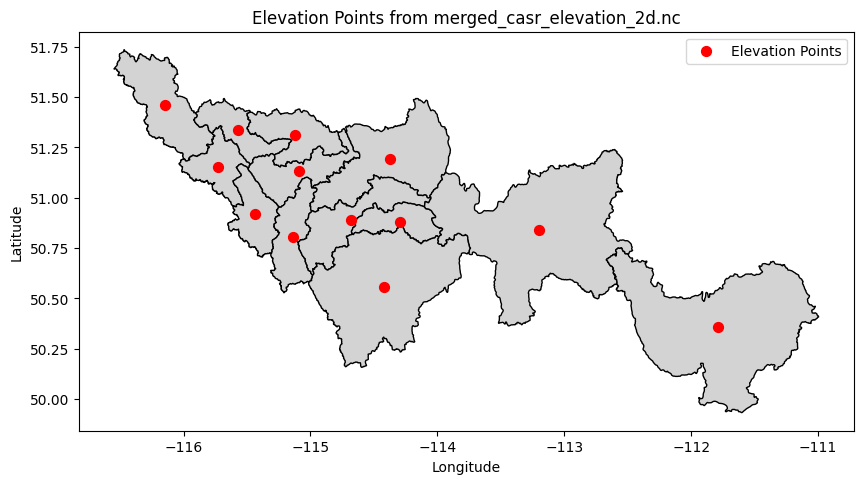

In [23]:
# Extract coordinates from merged_ds (already loaded from merged_casr_elevation_2d.nc)
lon = merged_ds['original_lon'].values
lat = merged_ds['original_lat'].values

# Create GeoDataFrame for elevation points
gdf_elev_points = gpd.GeoDataFrame(
    {'lon': lon, 'lat': lat},
    geometry=gpd.points_from_xy(lon, lat),
    crs='EPSG:4326'
)

# Read the shapefile using geopandas (if not already loaded)
bow_elevation = gpd.read_file(config['shapefile_dir'])
if bow_elevation.crs is None:
    bow_elevation.set_crs(epsg=4326, inplace=True)

# Plot elevation points on top of the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_elev_points.plot(ax=ax, color='red', markersize=50, label='Elevation Points')
ax.set_title('Elevation Points from merged_casr_elevation_2d.nc')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [9]:
# Step 1: List all SWE files using the correct data_path variable
file_pattern = str(config['casr_SWE_input_dir'] / "CaSR_v3.1_P_SWE_LAND_*.nc")
file_list = sorted(glob.glob(file_pattern))

if not file_list:
    raise FileNotFoundError(f"No files found with pattern {file_pattern}")

# Step 2: Open and combine them using xarray
ds_combined_swe = xr.open_mfdataset(
    file_list,
    combine='by_coords',  # will automatically align by time and coordinates
    parallel=True,        # if using Dask or want faster loading
    engine='netcdf4'      # or 'h5netcdf' if you're using that backend
)

# Optional: Check dataset structure
print(ds_combined_swe)




<xarray.Dataset> Size: 23GB
Dimensions:               (rlon: 70, rlat: 70, time: 394488)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1979-12-31T13:00:00 ... 2...
  * rlat                  (rlat) float64 560B -9.45 -9.36 -9.27 ... -3.33 -3.24
  * rlon                  (rlon) float64 560B -16.5 -16.41 ... -10.38 -10.29
    lon                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
    lat                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
Data variables:
    rotated_pole          (rlon, rlat, time) float64 15GB nan nan ... 1.0 1.0
    CaSR_v3.1_P_SWE_LAND  (time, rlat, rlon) float32 8GB dask.array<chunksize=(1, 35, 35), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    source:       https://hpfx.collab.science.gc.ca/~scar700/rcas-casr/
    institution:  Environment and Climate Change Canada / Environnement et Ch...
    title:        Canadian Surface Reanalysis (CaSR) / Réanalyse Can

In [10]:
# Select a small subset (e.g., first time step) to avoid MemoryError
subset = ds_combined_swe.isel(time=0)
swe_df = ds_combined_swe.to_dataframe().reset_index()
display(swe_df)


KeyboardInterrupt: 

In [6]:
# Extract SWE values and coordinates inside a GeoDataFrame
gdf_swe = gpd.GeoDataFrame(
    swe_df,
    geometry=gpd.points_from_xy(swe_df['lon'], swe_df['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)
# convert lon from 0-360 to -180 to 180 format
gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
# Update geometry to reflect new longitude values
gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])

# Display the GeoDataFrame
display(gdf_swe.head())

,rlon,rlat,rotated_pole,CaSR_v3.1_P_SWE_LAND,time,lon,lat,geometry
0,-16.497223,-9.450001,NaN,NaN,1979-12-31 13:00:00,NaN,NaN,POINT (NaN NaN)
1,-16.497223,-9.360001,NaN,NaN,1979-12-31 13:00:00,NaN,NaN,POINT (NaN NaN)
2,-16.497223,-9.270000,NaN,NaN,1979-12-31 13:00:00,NaN,NaN,POINT (NaN NaN)
3,-16.497223,-9.180000,NaN,NaN,1979-12-31 13:00:00,NaN,NaN,POINT (NaN NaN)
4,-16.497223,-9.090000,NaN,NaN,1979-12-31 13:00:00,NaN,NaN,POINT (NaN NaN)


In [21]:

# Read the shapefile using geopandas
bow_elevation = gpd.read_file(config['shapefile_dir'])
# Set CRS if not already set (assume WGS84)
if bow_elevation.crs is None:
	bow_elevation.set_crs(epsg=4326, inplace=True)
# Ensure the CRS of the GeoDataFrame matches the gdf_swe
#bow_elevation = bow_elevation.to_crs(gdf_swe.crs)
# Display the first few rows of the GeoDataFrame
display(bow_elevation.head())

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,None,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,None,500_1000m,"POLYGON ((-112.4962 50.71881, -112.49566 50.71..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,None,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,None,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.0975 50.95..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,None,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


In [8]:
# extract data points inside the shapefile
gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
# Display the clipped GeoDataFrame
display(gdf_swe_clipped.head())


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_34192\788318178.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4617

  gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)


,rlon,rlat,rotated_pole,CaSR_v3.1_P_SWE_LAND,time,lon,lat,geometry
2002,-13.977219,-5.67,1.0,NaN,1979-12-31 13:00:00,-114.491516,50.269768,POINT (-114.49152 50.26977)
3253,-12.357224,-6.48,1.0,NaN,1979-12-31 13:00:00,-111.714264,49.984459,POINT (-111.71426 49.98446)
3184,-12.447220,-6.39,1.0,NaN,1979-12-31 13:00:00,-111.887512,50.045334,POINT (-111.88751 50.04533)
3255,-12.357224,-6.30,1.0,NaN,1979-12-31 13:00:00,-111.793793,50.157074,POINT (-111.79379 50.15707)
3116,-12.537216,-6.21,1.0,NaN,1979-12-31 13:00:00,-112.101685,50.192112,POINT (-112.10168 50.19211)


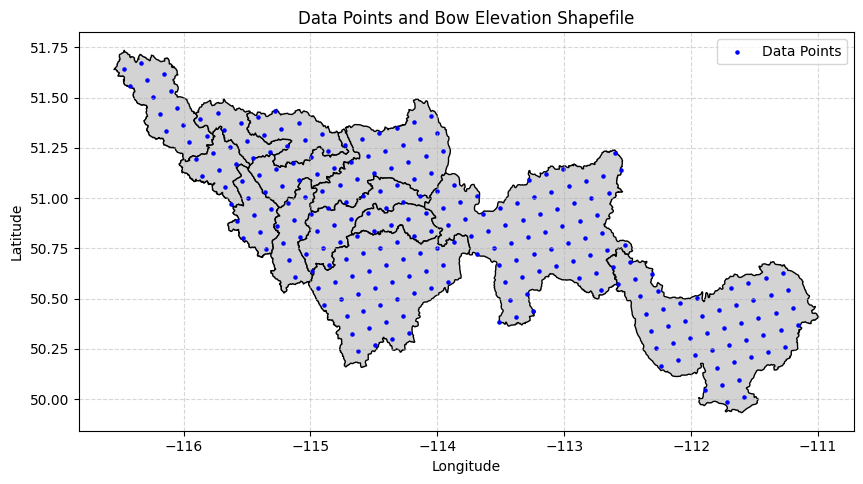

In [9]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_swe_clipped.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [19]:
# Read the shapefile using geopandas
bow_elevation = gpd.read_file(config['shapefile_dir'])
# Set CRS if not already set (assume WGS84)
if bow_elevation.crs is None:
    bow_elevation.set_crs(epsg=4326, inplace=True)
print(f"Bow elevation shapefile CRS: {bow_elevation.crs}")  

display(bow_elevation.head())

Bow elevation shapefile CRS: EPSG:4617


,PROVCD_1,PROVCD_2,PROVCD_3,PROVCD_4,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,OCEAN,WSCMDANAME,WSCSDANAME,WSCSSDANAM,geometry
0,AB,None,None,None,20070319,1,05BA000,0,NHN-CL1,05,05B,05BA,05BA,Hudson Bay,Nelson River Drainage Area,Bow,Headwaters Bow,"POLYGON ((-116.25388 51.71161, -116.25374 51.7..."
1,AB,None,None,None,20070315,1,05BB000,0,NHN-CL1,05,05B,05BB,05BB,Hudson Bay,Nelson River Drainage Area,Bow,Upper Bow - Redearth,"POLYGON ((-115.4726 51.16677, -115.47276 51.16..."
2,AB,BC,None,None,20111128,2,05BC000,0,NHN-CL1,05,05B,05BC,05BC,Hudson Bay,Nelson River Drainage Area,Bow,Spray,"POLYGON ((-115.60862 50.95877, -115.6086 50.95..."
3,AB,None,None,None,20070305,1,05BD000,0,NHN-CL1,05,05B,05BD,05BD,Hudson Bay,Nelson River Drainage Area,Bow,Cascade,"POLYGON ((-115.47641 51.42722, -115.47702 51.4..."
4,AB,None,None,None,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,Hudson Bay,Nelson River Drainage Area,Bow,Upper Bow - Policeman,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


In [ ]:
# List all NetCDF files
file_pattern = str(config['casr_SWE_input_dir'] / "CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455*.nc")
file_list = sorted(glob.glob(file_pattern))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()
    
    # Create GeoDataFrame
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )
    # Convert lon from 0-360 to -180 to 180 format
    gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
    gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])
    
    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
    
    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data
all_clipped = pd.concat(clipped_list, ignore_index=True)

# Define output_path if not already defined
output_path = str(config['combined_casr_dir']) + os.sep

# Save to CSV
output_file = config['casr_SWE_input_dir'] / 'bow_swe_data_rlon246-280_rlat421-455.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
#display(all_clipped.head())

Bow elevation shapefile CRS: EPSG:4617
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_1980-1983.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_1984-1987.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_1988-1991.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE\CaSR_v3.1_P_SWE_LAND_rlon246-280_rlat421-455_1992-1995.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Document

In [7]:
# open csv files
bow_swe_data1 = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_rlon211-245_rlat421-455.csv')
bow_swe_data2 = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_rlon246-280_rlat421-455.csv')
bow_swe_data3 = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_rlon246-280_rlat386-420.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
bow_swe_data1 = bow_swe_data1.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
bow_swe_data2 = bow_swe_data2.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
bow_swe_data3 = bow_swe_data3.dropna(subset=['CaSR_v3.1_P_SWE_LAND'])
# concatenate all dataframes
bow_swe_data = pd.concat([bow_swe_data1, bow_swe_data2, bow_swe_data3], ignore_index=True)
# Save the combined data to a CSV file
output_file_combined = config['casr_SWE_input_dir'] / 'bow_swe_data_combined.csv'
bow_swe_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_swe_data.head())

Combined SWE data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_SWE\bow_swe_data_combined.csv


,time,rlat,rlon,rotated_pole,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.878418,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.515625,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,6.875000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,118.125000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.000000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)


In [8]:
#convert lon from 0-360 to -180 to 180 format
bow_swe_data['lon'] = ((bow_swe_data['lon'] + 180) % 360) - 180


# convert to GeoDataFrame
gdf_bow_swe_data = gpd.GeoDataFrame(
    bow_swe_data,
    geometry=gpd.points_from_xy(bow_swe_data['lon'], bow_swe_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_swe_data.head())

,time,rlat,rlon,rotated_pole,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.878418,-116.13797,51.334590,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.515625,-116.13797,51.334590,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,6.875000,-116.18750,51.419113,POINT (-116.1875 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,118.125000,-116.18750,51.419113,POINT (-116.1875 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.000000,-116.18750,51.419113,POINT (-116.1875 51.41911)


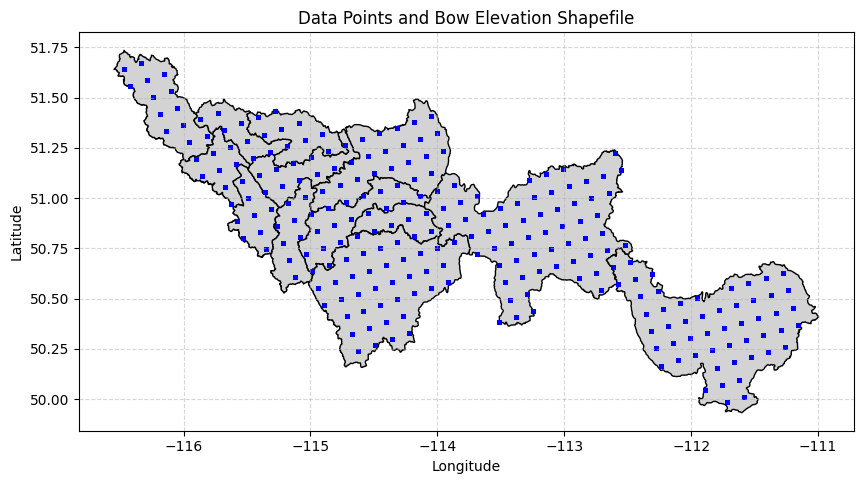

In [9]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_bow_swe_data.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# 2. Open all precipitation data files and combine them into a single xarray dataset spatially and temporally


In [7]:
# List all NetCDF files
file_pattern = str(config['casr_P_input_dir'] / 'CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455*.nc')
file_list = sorted(glob.glob(file_pattern))

# Prepare an empty list to collect clipped data
clipped_list = []

for nc_file in file_list:
    swe = xr.open_dataset(nc_file)
    dataframe = swe.to_dataframe().reset_index()
    
    # Create GeoDataFrame
    gdf_swe = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['lon'], dataframe['lat']),
        crs='EPSG:4326'
    )
    # Convert lon from 0-360 to -180 to 180 format
    gdf_swe['lon'] = ((gdf_swe['lon'] + 180) % 360) - 180
    gdf_swe['geometry'] = gpd.points_from_xy(gdf_swe['lon'], gdf_swe['lat'])
    
    # Clip to shapefile
    gdf_swe_clipped = gpd.clip(gdf_swe, bow_elevation)
    
    # Append to list
    clipped_list.append(gdf_swe_clipped)
    print(f"Processed {nc_file}: {len(gdf_swe_clipped)} points clipped.")

# Concatenate all clipped data
all_clipped = pd.concat(clipped_list, ignore_index=True)

# Save to CSV
output_file = config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat421-455.csv'
all_clipped.to_csv(output_file, index=False)
print(f"Extracted SWE data saved to {output_file}")

# Display a sample
#display(all_clipped.head())

Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1980-1983.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1984-1987.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1988-1991.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1992-1995.nc: 3751848 points clipped.
Processed c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documen

In [8]:
# open csv files
bow_precip_data1 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon211-245_rlat421-455.csv')
bow_precip_data2 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat421-455.csv')
bow_precip_data3 = pd.read_csv(config['casr_P_input_dir'] / 'bow_precip_data_rlon246-280_rlat386-420.csv')

# drop rows with NaN CaSR_v3.1_P_SWE_LAND
bow_precip_data1 = bow_precip_data1.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data2 = bow_precip_data2.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
bow_precip_data3 = bow_precip_data3.dropna(subset=['CaSR_v3.1_A_PR24_SFC'])
# concatenate all dataframes
bow_precip_data = pd.concat([bow_precip_data1, bow_precip_data2, bow_precip_data3], ignore_index=True)
# Save the combined data to a CSV file
output_file_combined = config['casr_P_input_dir'] / 'bow_precip_data_combined.csv'
bow_precip_data.to_csv(output_file_combined, index=False)  
print(f"Combined SWE data saved to {output_file_combined}")
# Display the combined data
display(bow_precip_data.head())

Combined SWE data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_precipitation\bow_precip_data_combined.csv


,time,rlat,rlon,rotated_pole,CaSR_v3.1_A_PR24_SFC,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.000010,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.002766,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,0.000024,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,0.004579,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.005400,-116.18750,51.419113,POINT (-116.1875 51.41911315917969)


In [9]:

#convert lon from 0-360 to -180 to 180 format
bow_precip_data['lon'] = ((bow_precip_data['lon'] + 180) % 360) - 180

# convert to GeoDataFrame
gdf_bow_precip_data = gpd.GeoDataFrame(
    bow_precip_data,
    geometry=gpd.points_from_xy(bow_precip_data['lon'], bow_precip_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_precip_data.head())

,time,rlat,rlon,rotated_pole,CaSR_v3.1_A_PR24_SFC,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.000010,-116.13797,51.334590,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.002766,-116.13797,51.334590,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,0.000024,-116.18750,51.419113,POINT (-116.1875 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,0.004579,-116.18750,51.419113,POINT (-116.1875 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.005400,-116.18750,51.419113,POINT (-116.1875 51.41911)


In [11]:
bow_swe_data = pd.read_csv(config['casr_SWE_input_dir'] / 'bow_swe_data_combined.csv')

#convert lon from 0-360 to -180 to 180 format
bow_swe_data['lon'] = ((bow_swe_data['lon'] + 180) % 360) - 180


# convert to GeoDataFrame
gdf_bow_swe_data = gpd.GeoDataFrame(
    bow_swe_data,
    geometry=gpd.points_from_xy(bow_swe_data['lon'], bow_swe_data['lat']),
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Display the GeoDataFrames
display(gdf_bow_swe_data.head())

,time,rlat,rlon,rotated_pole,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.878418,-116.13797,51.334590,POINT (-116.13797 51.33459)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.515625,-116.13797,51.334590,POINT (-116.13797 51.33459)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,6.875000,-116.18750,51.419113,POINT (-116.1875 51.41911)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,118.125000,-116.18750,51.419113,POINT (-116.1875 51.41911)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.000000,-116.18750,51.419113,POINT (-116.1875 51.41911)


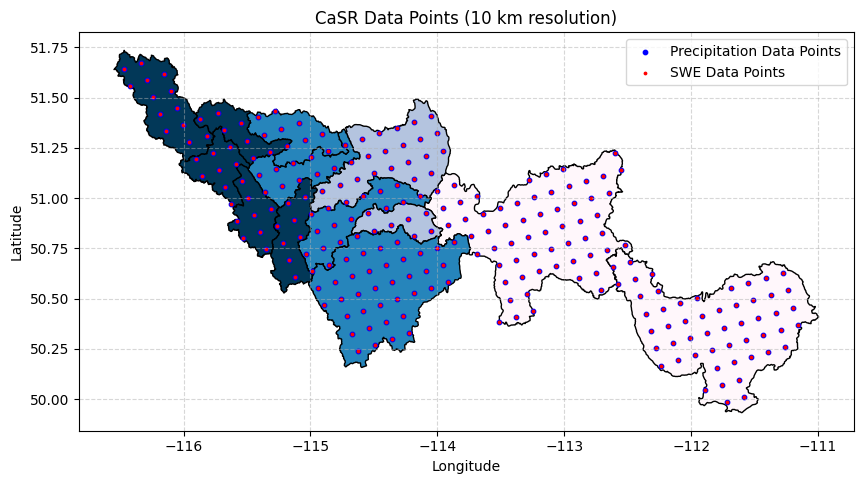

In [22]:
# drop repeated coordinates based on geometry column
gdf_bow_precip_data1 = gdf_bow_precip_data.drop_duplicates(subset="geometry")
gdf_bow_swe_data1 = gdf_bow_swe_data.drop_duplicates(subset="geometry")

# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))

# Create elevation class column based on available elevation field.
# Many shapefiles use different column names; try common candidates and fall back to 'Unknown'
bins = [500, 1000, 1500, 2000, 2500]
labels = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

# Try a list of possible elevation column names
elev_candidates = [
    'mean', 'elev_mean', 'ELEV_MEAN', 'elevation', 'ELEVATION',
    'MEAN_ELEV', 'elev', 'ELEV', 'VALUE', 'VAL', 'MEAN'
]

elev_col = None
for c in elev_candidates:
    if c in bow_elevation.columns:
        elev_col = c
        break

if elev_col is not None:
    # ensure numeric dtype
    bow_elevation['__elev_tmp'] = pd.to_numeric(bow_elevation[elev_col], errors='coerce')
    bow_elevation['elev_class'] = pd.cut(bow_elevation['__elev_tmp'], bins=bins, labels=labels, include_lowest=True, right=False)
    # Ensure elev_class is a categorical type with desired order
    bow_elevation['elev_class'] = pd.Categorical(
        bow_elevation['elev_class'],
        categories=labels,
        ordered=True
    )
    bow_elevation.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
    # drop temporary column
    bow_elevation.drop(columns='__elev_tmp', inplace=True)
else:
    # No elevation column found — create an 'Unknown' category and plot without classification
    bow_elevation['elev_class'] = 'Unknown'
    bow_elevation['elev_class'] = pd.Categorical(bow_elevation['elev_class'], categories=['Unknown'], ordered=False)
    bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black', label='Bow Elevation')

# Plot the deduplicated CaSR points (smaller sets) to avoid massive plotting
gdf_bow_precip_data1.plot(ax=ax, color='blue', markersize=10, label='Precipitation Data Points')
gdf_bow_swe_data1.plot(ax=ax, color='red', markersize=3, label='SWE Data Points')

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('CaSR Data Points (10 km resolution)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Save plot
plt.savefig(config['plots'] / 'bow_data_points_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# Merge SWE and Precipitation data on time, lon, and lat
combined_data = pd.merge(
    bow_swe_data,
    bow_precip_data,
    on=['time', 'lon', 'lat'],
    suffixes=('_swe', '_precip')
)

# Display the first few rows of the combined dataframe
display(combined_data.head())

,time,rlat_swe,rlon_swe,rotated_pole_swe,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry_swe,rlat_precip,rlon_precip,rotated_pole_precip,CaSR_v3.1_A_PR24_SFC,geometry_precip
0,1980-10-10 12:00:00,-4.32,-14.607224,1,0.878418,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234),-4.32,-14.607224,1,0.000010,POINT (-116.13796997070312 51.334590911865234)
1,1982-07-19 12:00:00,-4.32,-14.607224,1,0.515625,-116.13797,51.334590,POINT (-116.13796997070312 51.334590911865234),-4.32,-14.607224,1,0.002766,POINT (-116.13796997070312 51.334590911865234)
2,1983-10-12 12:00:00,-4.23,-14.607224,1,6.875000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.000024,POINT (-116.1875 51.41911315917969)
3,1980-12-11 12:00:00,-4.23,-14.607224,1,118.125000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.004579,POINT (-116.1875 51.41911315917969)
4,1981-07-21 12:00:00,-4.23,-14.607224,1,0.000000,-116.18750,51.419113,POINT (-116.1875 51.41911315917969),-4.23,-14.607224,1,0.005400,POINT (-116.1875 51.41911315917969)


In [24]:
# Rename columns to standard names for easier use
combined_data = combined_data.rename(
	columns={
		'CaSR_v3.1_P_SWE_LAND': 'SWE',
		'CaSR_v3.1_A_PR24_SFC': 'Precipitation'
	}
)

#keep only the columns of interest (use the already renamed columns)
combined_data = combined_data[['time', 'lon', 'lat', 'SWE', 'Precipitation']]

#conver back to dataframe
combined_data = pd.DataFrame(combined_data)

# convert precipitation from m to mm
combined_data['Precipitation'] = combined_data['Precipitation'] * 1000  # Convert from meters to millimeters
# Convert SWE from kg/m^2 to mm (assuming density of water is 1000 kg/m^3)

# Convert 'time' column to datetime format
combined_data['time'] = pd.to_datetime(combined_data['time']).dt.date

# add a new column Grid_id with unique values based on lat and lon
# Assign unique integer Grid_id for each unique (lat, lon) pair
unique_coords = combined_data[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
unique_coords['Grid_id'] = range(1, len(unique_coords) + 1)
combined_data = combined_data.merge(unique_coords, on=['lat', 'lon'], how='left')
combined_data['Grid_id'] = combined_data['Grid_id'].astype(int)

# Reorder columns to have 'Grid_id' at the beginning and use new column names
combined_data = combined_data[['Grid_id', 'time', 'lon', 'lat', 'SWE', 'Precipitation']]

# Save the combined data to a CSV file
output_file_combined = config['merged_output_dir'] / 'bow_combined_data.csv'
combined_data.to_csv(output_file_combined, index=False)
print(f"Combined data saved to {output_file_combined}")
# Display the first few rows of the combined dataframe
display(combined_data)

Combined data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d\bow_combined_data.csv


,Grid_id,time,lon,lat,SWE,Precipitation
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473
...,...,...,...,...,...,...
4224304,257,2024-06-30,-111.62024,50.096050,0.000000,0.000000
4224305,257,2024-08-31,-111.62024,50.096050,0.000000,0.000000
4224306,257,2024-09-28,-111.62024,50.096050,0.000000,0.076506
4224307,257,2024-01-05,-111.62024,50.096050,0.625000,0.019896


In [25]:
# Prepare a GeoDataFrame for unique grid points
grid_points = gpd.GeoDataFrame(
    unique_coords,
    geometry=gpd.points_from_xy(unique_coords['lon'], unique_coords['lat']),
    crs='EPSG:4326'
)

# Spatial join to assign elevation class to each grid point
grid_points_with_elev = gpd.sjoin(grid_points, bow_elevation[['elev_class', 'geometry']], how='left', predicate='within')

# Merge elevation class back to combined_data
combined_data = combined_data.merge(
    grid_points_with_elev[['Grid_id', 'elev_class']],
    on='Grid_id',
    how='left'
)

# Rename the column for clarity
combined_data = combined_data.rename(columns={'elev_class': 'Elevation_Category'})

# Display the updated dataframe
display(combined_data)

,Grid_id,time,lon,lat,SWE,Precipitation,Elevation_Category
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879,2000_2500m
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854,2000_2500m
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846,2000_2500m
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907,2000_2500m
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473,2000_2500m
...,...,...,...,...,...,...,...
4224304,257,2024-06-30,-111.62024,50.096050,0.000000,0.000000,500_1000m
4224305,257,2024-08-31,-111.62024,50.096050,0.000000,0.000000,500_1000m
4224306,257,2024-09-28,-111.62024,50.096050,0.000000,0.076506,500_1000m
4224307,257,2024-01-05,-111.62024,50.096050,0.625000,0.019896,500_1000m


In [26]:
# Save the combined data to a CSV file
output_file_combined = config['merged_output_dir'] / 'bow_combined_data.csv'
combined_data.to_csv(output_file_combined, index=False)
print(f"Combined data with elevation categories saved to {output_file_combined}")

Combined data with elevation categories saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\merged_2d\bow_combined_data.csv
